In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [14]:
def hp(level, base_points):
    return (140 * 2 + 31 + base_points / 4) * level / 100 + 10 + level


def defense(level, base_points, modifier=1.0):
    return ((95 * 2 + 31 + base_points / 4) * level / 100 + 5) * modifier


def damage(level, attack, defense):
    return ((2 * level + 10) / 250) * attack / defense + 2


In [32]:
level = 100

defense_base_points = np.array(range(1, 129))

eternatus_hp_remained = []

ability_powers = [60, 80, 100, 120, 140, 160]
ability_powers = [200]

for power in ability_powers:
    attack = 300 * power
    # attack = np.array(range(100, 30100, 100))
    # defense_base_points, attack = np.meshgrid(defense_base_points, attack)

    hp_base_points = np.array([(252 - 2 * pts) for pts in defense_base_points])
    eternatus_defense = defense(level, defense_base_points)
    eternatus_hp = hp(level, hp_base_points)
    eternatus_damage = damage(level, attack, eternatus_defense)
    eternatus_hp_remained.append((eternatus_hp - eternatus_damage) / eternatus_hp)


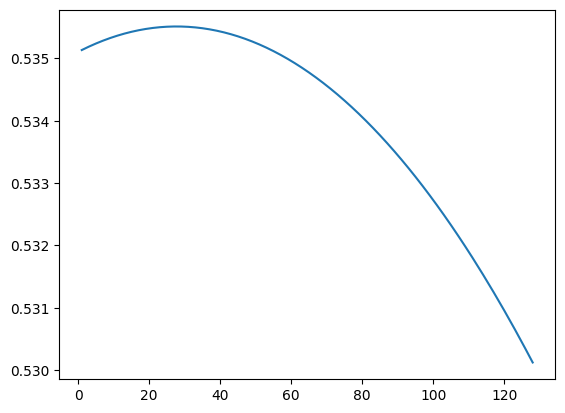

In [33]:
plt.figure()

for i, power in enumerate(ability_powers):
    plt.plot(defense_base_points, eternatus_hp_remained[i])

plt.show()


Optimal Defense Points: [tensor(27.3286), tensor(44.0735), tensor(56.8049), tensor(66.5623), tensor(74.0852), tensor(79.9131), tensor(84.4457), tensor(87.9829), tensor(90.7522), tensor(92.9270), tensor(94.6404), tensor(95.9943), tensor(97.0683), tensor(97.9231), tensor(98.6066), tensor(99.1557), tensor(99.5990), tensor(99.9589), tensor(100.2530), tensor(100.4950), tensor(100.6957), tensor(100.8634), tensor(101.0047), tensor(101.1249), tensor(101.2279), tensor(101.3171), tensor(101.3950), tensor(101.4636), tensor(101.5245), tensor(101.5789), tensor(101.6281), tensor(101.6727), tensor(101.7135), tensor(101.7509), tensor(101.7853), tensor(101.8175)] [tensor(0.0945), tensor(0.1404), tensor(0.2165), tensor(0.3792), tensor(0.0635), tensor(0.3333), tensor(0.1420), tensor(0.4518), tensor(0.5311), tensor(0.3562), tensor(1.2386), tensor(0.6859), tensor(1.4340), tensor(0.4581), tensor(1.0316), tensor(1.6022), tensor(0.1176), tensor(0.4711), tensor(0.8460), tensor(1.1928), tensor(1.4734), tensor(1

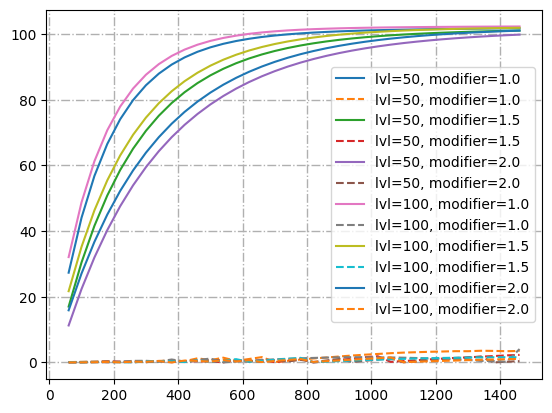

In [20]:
import matplotlib.pyplot as plt
import torch


C_HP_SPECIES_STRENGTH = 130
C_DEFENSE_SPECIES_STRENGTH = 80
C_SPECIAL_DEFENSE_SPECIES_STRENGTH = 95


class DamageCalculator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.defense_base_points = torch.nn.Parameter(torch.zeros(1))
        self.special_defense_base_points = torch.nn.Parameter(torch.zeros(1))

    def _damage(self, species_strength, base_points, attack):
        defense = (
            (species_strength * 2 + 31 + base_points / 4) * level / 100 + 5
        ) * modifier
        return (2 * level + 10) / 250 * attack / defense + 2

    def forward(self, level, attack, modifier):
        hp_base_points = (
            256
            - torch.clamp(self.defense_base_points, min=0, max=252)
            - torch.clamp(self.special_defense_base_points, min=0, max=252)
        )
        hp = (
            (C_HP_SPECIES_STRENGTH * 2 + 31 + hp_base_points / 4) * level / 100
            + 10
            + level
        )
        return (
            self._damage(C_DEFENSE_SPECIES_STRENGTH, self.defense_base_points, attack)
            + self._damage(
                C_SPECIAL_DEFENSE_SPECIES_STRENGTH,
                self.special_defense_base_points,
                attack,
            )
        ) / hp


ability_powers = list(range(60, 1500, 40))

plt.figure()


def _plot_optimal_defense_points(level, modifier):
    optimal_defense_points = []
    optimal_special_defense_points = []

    for power in ability_powers:
        calculator = DamageCalculator()
        optimizer = torch.optim.SGD(calculator.parameters(), lr=1e3)

        def _update():
            optimizer.zero_grad()
            loss = calculator(level, 3 * level * power, modifier)
            loss.backward()

            orig_defense_base_points = torch.clone(
                calculator.defense_base_points[0].detach()
            )
            orig_special_defense_base_points = torch.clone(
                calculator.special_defense_base_points[0].detach()
            )

            optimizer.step()

            updated_defense_base_points = calculator.defense_base_points[0]
            updated_special_defense_base_points = (
                calculator.special_defense_base_points[0]
            )

            return (
                abs(orig_defense_base_points - updated_defense_base_points).detach()
                + abs(
                    orig_special_defense_base_points
                    - updated_special_defense_base_points
                ).detach()
            )

        for _ in range(int(1e3)):
            if _update() < 2e-4:
                break

        optimal_defense_points.append(
            torch.clone(calculator.defense_base_points[0].detach())
        )
        optimal_special_defense_points.append(
            torch.clone(calculator.special_defense_base_points[0].detach())
        )

    print(
        "Optimal Defense Points:",
        optimal_defense_points,
        optimal_special_defense_points,
    )

    plt.plot(
        ability_powers,
        optimal_defense_points,
        label=f"lvl={level}, modifier={modifier}",
    )

    plt.plot(
        ability_powers,
        optimal_special_defense_points,
        linestyle="--",
        label=f"lvl={level}, modifier={modifier}",
    )


for level in [50, 100]:
    for modifier in [1.0, 1.5, 2.0]:
        _plot_optimal_defense_points(level, modifier)

plt.legend()
plt.grid(linestyle="-.", linewidth=1)
plt.show()
